# Setup

In [1]:
!pip install tensorflow_addons
!pip install pyDOE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=525b1fd23f8b3fc3f4ba0ec2a12e29cfa29819f2822baec71e68b9e370e8e214
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import time
import scipy

# Define PINN and EulerPINN

In [3]:
from typing_extensions import get_overloads
from re import U
"""
@author: Yongji Wang (modified from Raissi)
"""

import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(123)
tf.random.set_seed(123)


class EulerPINN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, alpha):

        self.lb = lb
        self.ub = ub

        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]

        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]

        self.N_f = X_f.shape[0]

        self.u = u

        self.layers = layers
        self.alpha = alpha

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss = self.loss_NN()


        self.normal_x = tf.cast(tf.where(self.x_u == 1., 1, tf.where(self.x_u == 0., -1, 0)), dtype=tf.float32)
        self.normal_t = tf.cast(tf.where(self.t_u == 1., 1, tf.where(self.t_u == 0., -1, 0)), dtype=tf.float32)



        # DEBUG

        n_tot = 10000
        self.xs = tf.cast(tf.linspace(0,1,n_tot)[:,None], dtype=tf.float32)
        self.x1 = tf.cast(tf.zeros(n_tot)[:,None], dtype=tf.float32)
        self.x2 = tf.cast(tf.ones(n_tot)[:,None], dtype=tf.float32)

        self.ys = tf.cast(tf.linspace(0,1,n_tot)[:,None], dtype=tf.float32)
        self.y1 = tf.cast(tf.zeros(n_tot)[:,None], dtype=tf.float32)
        self.y2 = tf.cast(tf.ones(n_tot)[:,None], dtype=tf.float32)


    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases



    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)



    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y


    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def resample_f(self):
        X_f = self.lb + (self.ub-self.lb)*lhs(2, self.N_f)
        X_f = tf.cast(X_f, dtype=tf.float32)
        self.x_f_sgd = X_f[:,0:1]
        self.t_f_sgd = X_f[:,1:2]

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u

    def governing_equation(self, u, u_x, u_t, x, t):
        f = u_x - t, u_t - self.alpha*x
        return f

    def net_f(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        f = self.governing_equation(u, u_x, u_t, x, t)
        return f


    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        #self.d_pred = self.net_dataloss(self.x_f, self.t_f)
        self.u_pred = self.net_u(self.x_u, self.t_u)
        self.f_pred = self.net_f(self.x_f, self.t_f)
        loss = tf.reduce_mean(tf.square(self.u_pred-self.u)) + \
               tf.reduce_mean(tf.square(self.f_pred[0])) + \
               tf.reduce_mean(tf.square(self.f_pred[1]))
        return loss

    @tf.function
    # calculate the physics-informed loss function
    def loss_NN_sgd(self):
        self.resample_f()

        self.u_pred = self.net_u(self.x_u, self.t_u)
        self.f_pred = self.net_f(self.x_f_sgd, self.t_f_sgd)
        loss = tf.reduce_mean(tf.square(self.u_pred-self.u)) + \
               tf.reduce_mean(tf.square(self.f_pred[0])) + \
               tf.reduce_mean(tf.square(self.f_pred[1]))
        return loss

    def net_f_and_derivatives(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        f = self.governing_equation(u, u_x, u_t, x, t)

        r2 = tf.square(f[0]) + tf.square(f[1])
        r2_u_x = tf.gradients(r2, u_x)[0]
        r2_u_t = tf.gradients(r2, u_t)[0]
        r2_u_xx = tf.gradients(r2_u_x, x)[0]
        r2_u_tt = tf.gradients(r2_u_t, t)[0]
        return r2, r2_u_x, r2_u_t, r2_u_xx, r2_u_tt

    def net_u_and_derivatives(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        f = self.governing_equation(u, u_x, u_t, x, t)

        r2 = tf.square(f[0]) + tf.square(f[1])
        r2_u_x = tf.gradients(r2, u_x)[0]
        r2_u_t = tf.gradients(r2, u_t)[0]
        return u, r2, r2_u_x, r2_u_t

    @tf.function
    # calculate the physics-informed loss function
    def Euler_loss(self):
        r2, r2_u_x, r2_u_t, r2_u_xx, r2_u_tt = self.net_f_and_derivatives(self.x_f, self.t_f)
        # Compute Euler-Lagrange for first order f:
        EL = - r2_u_xx - r2_u_tt
        self.energy = tf.reduce_mean(tf.square(EL))

        u, r2, r2_u_x, r2_u_t = self.net_u_and_derivatives(self.x_u, self.t_u)
        # Compute neumann conditions
        r2_u_normal = self.normal_x * r2_u_x + self.normal_t * r2_u_t
        self.neumann12 = tf.reduce_mean(tf.square((u-self.u)/2 + r2_u_normal))

        return self.energy + self.neumann12


    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self):
        # obtain the shapes of all trainable parameters in the model
        varlist = self.train_variables
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = [] # stitch indices
        part = [] # partition indices

        self.start_time = time.time()

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            part.extend([i]*n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                self.train_variables[i].assign(tf.reshape(param, shape))


        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                euler_loss = self.Euler_loss()
                #loss_valueother = self.loss_NNother()
                #euler_loss = self.Euler_loss()
                old_loss = self.loss_NN()
                sgd_loss = self.loss_NN_sgd()

            loss_value = euler_loss
            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_value, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss values so we can retrieve later
            #tf.py_function(f.history_euler.append, inp=[euler_loss.numpy()], Tout=[])
            tf.py_function(lambda x: f.history_euler.append(x.numpy()), inp=[euler_loss], Tout=[])
            #tf.py_function(f.history_old.append, inp=[old_loss.numpy()], Tout=[])
            tf.py_function(lambda x: f.history_old.append(x.numpy()), inp=[old_loss], Tout=[])
            tf.py_function(lambda x: f.history_sgd.append(x.numpy()), inp=[sgd_loss], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            if f.iter % 10 == 0:
                #tf.print("Iter:", f.iter, "loss:", loss_value, 'real other loss:', loss_valueother, 'euler loss:', euler_loss, 'other loss:', other_loss_value, 'other loss2:', other_loss_value2, 'other loss3:', other_loss_value3, 'other loss4:', other_loss_value4, 'other loss5:', other_loss_value5)
                tf.print("Iter:", f.iter, "Euler loss:", euler_loss, 'old loss:', old_loss, 'sgd loss:', sgd_loss)

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.history_euler = []
        f.history_old = []
        f.history_sgd = []

        return f


    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter):

        func = self.Lbfgs_function()

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, self.train_variables)

        max_nIter = tf.cast(nIter/3, dtype = tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func.history_euler, func.history_old, func.history_sgd


    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter):
        # running the Lbfgs optimization
        loss_history_euler, loss_history_old, loss_history_sgd = self.Lbfgs_optimizer(nIter)

        return loss_history_euler, loss_history_old, loss_history_sgd


    @tf.function
    def predict(self, X_star):
        u_star = self.net_u(X_star[:,0:1], X_star[:,1:2])
        f_star = self.net_f(X_star[:,0:1], X_star[:,1:2])
        return u_star, f_star

## Load data and helper functions

In [4]:
def get_perimeter(num_per_side):

  # Define the number of points along each side of the square
  num_points_per_side = num_per_side

  # Generate points along the perimeter of the unit square [0,1] x [0,1]
  perimeter_points = []

  # Top side
  for i in range(num_points_per_side):
      perimeter_points.append([i / (num_points_per_side - 1), 0.0])

  # Right side
  for i in range(1, num_points_per_side):
      perimeter_points.append([1.0, i / (num_points_per_side - 1)])

  # Bottom side
  for i in range(num_points_per_side - 2, -1, -1):
      perimeter_points.append([i / (num_points_per_side - 1), 1.0])

  # Left side
  for i in range(num_points_per_side - 2, 0, -1):
      perimeter_points.append([0.0, i / (num_points_per_side - 1)])

  # Convert the list of points to a TensorFlow tensor
  perimeter_points_tensor = tf.constant(perimeter_points)

  print("Points along the perimeter of the unit square:")
  #print(perimeter_points_tensor)
  return perimeter_points_tensor

u_groundtruth = lambda x, t: x*t

x = np.linspace(0, 1, 1000)[:,None]
y = np.linspace(0, 1, 1000)[:,None]
X, T = np.meshgrid(x, y)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
#u_star = Exact.flatten()[:,None]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

X_u_train = get_perimeter(10000).numpy()
u_train = u_groundtruth(X_u_train[:,0:1], X_u_train[:,1:2])
print(X_u_train.shape, u_train.shape)

Points along the perimeter of the unit square:
(39996, 2) (39996, 1)


In [5]:
def moving_average(arr, window_size):
    # Ensure window_size is an integer and greater than 0
    window_size = int(window_size)
    if window_size <= 0:
        raise ValueError("window_size must be greater than 0")

    # Create the window for the moving average
    window = np.ones(window_size) / window_size

    # Use np.convolve to calculate the moving average
    moving_avg = np.convolve(arr, window, mode='valid')

    return moving_avg

# Example usage
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
window_size = 3
smoothed_arr = moving_average(arr, window_size)

print("Original array:", arr)
print("Smoothed array:", smoothed_arr)

Original array: [1 2 3 4 5 6 7 8 9]
Smoothed array: [2. 3. 4. 5. 6. 7. 8.]


# Experiments

## Well-specified case

In [6]:
# Well-specified:

alpha = 1

Iter: 10 Euler loss: 1.23488498 old loss: 0.296091616 sgd loss: 0.296510518
Iter: 20 Euler loss: 1.30106807 old loss: 0.363521069 sgd loss: 0.363285959
Iter: 30 Euler loss: 0.468614638 old loss: 0.192251444 sgd loss: 0.192431182
Iter: 40 Euler loss: 0.445685029 old loss: 0.170622975 sgd loss: 0.170621842
Iter: 50 Euler loss: 0.40132767 old loss: 0.175962374 sgd loss: 0.176027074
Iter: 60 Euler loss: 0.464580506 old loss: 0.424244165 sgd loss: 0.424363732
Iter: 70 Euler loss: 0.314758152 old loss: 0.262459725 sgd loss: 0.262404442
Iter: 80 Euler loss: 0.252715707 old loss: 0.100510404 sgd loss: 0.100378953
Iter: 90 Euler loss: 0.15116021 old loss: 0.0486660115 sgd loss: 0.0485912263
Iter: 100 Euler loss: 0.130028039 old loss: 0.031827379 sgd loss: 0.0317811258
Iter: 110 Euler loss: 0.0991836861 old loss: 0.032114815 sgd loss: 0.0320363119
Iter: 120 Euler loss: 0.0915169641 old loss: 0.0362652652 sgd loss: 0.0361742154
Iter: 130 Euler loss: 0.060333278 old loss: 0.0208775476 sgd loss: 0.

/tmp/ipython-input-2443872490.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc = 'best')


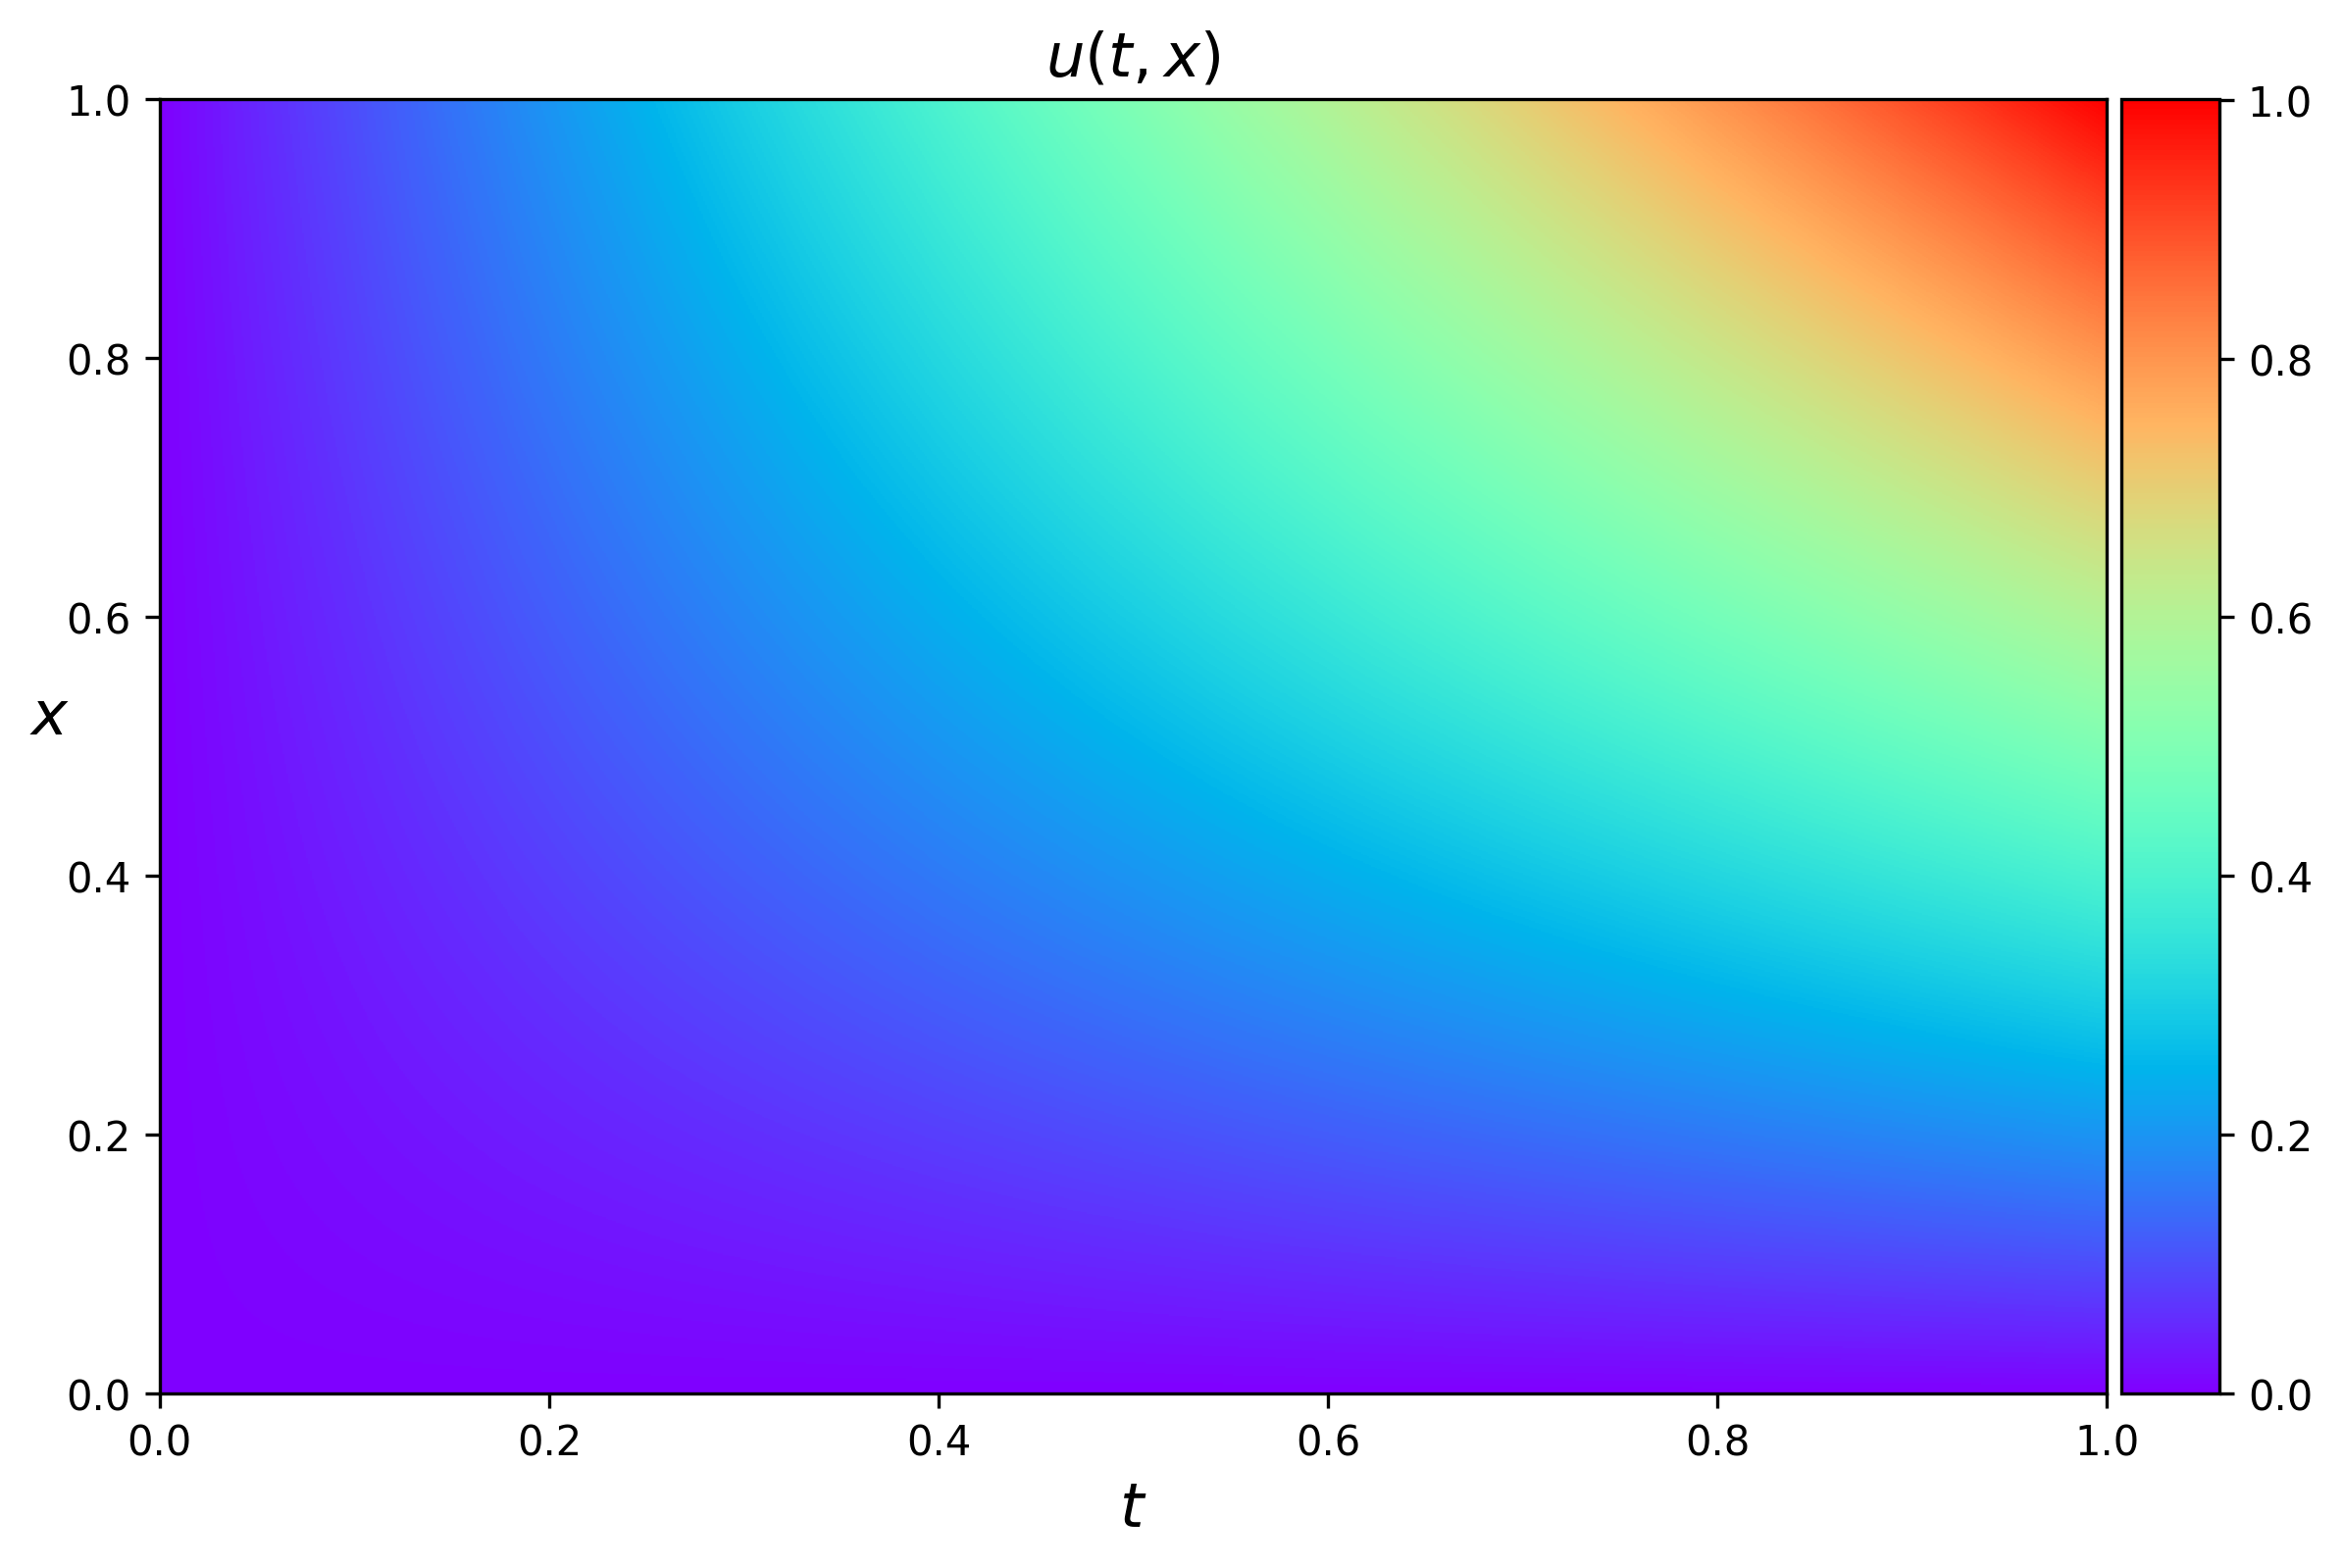

In [7]:
num_iter = 1000

N_u = 1000
N_f = 10000

xy = np.mgrid[0:1:1/1000, 0:1:1/1000].reshape(2, -1).T
X_f_train = xy

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)

model_un = EulerPINN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha)

start_time = time.time()
energy, loss, sgd = model_un.train(num_iter)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model_un.predict(X_star)

F_pred = tf.reshape(tf.square(f_pred[0]) + tf.square(f_pred[1]), X.shape)
U_pred = tf.reshape(u_pred, X.shape)

######################################################################
############################# Plotting ###############################
######################################################################

fig = plt.figure(figsize = [10, 10], dpi = 300)

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.numpy().T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$', fontsize = 15)
ax.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax.set_title('$u(t,x)$', fontsize = 15)
ax.legend(frameon=False, loc = 'best')

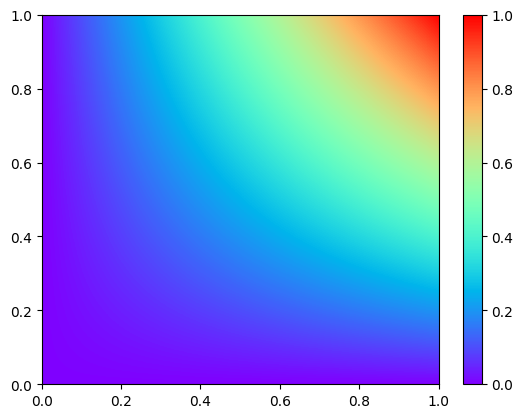

In [8]:
U_pred_1 = U_pred.numpy()
plt.imshow(U_pred_1.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar()

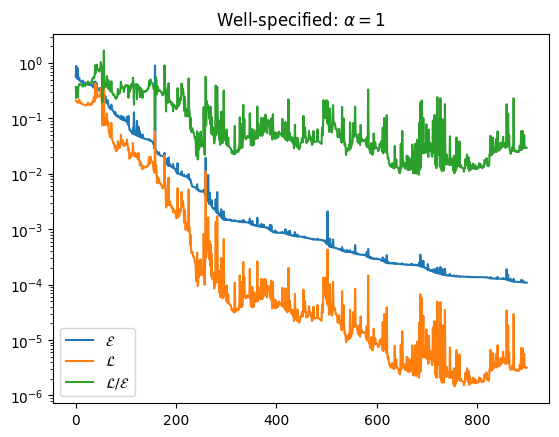

In [9]:
window_size = 1
energy_avg = moving_average(energy[10:], window_size)
loss_avg = moving_average(loss[10:], window_size)
sgd_avg = moving_average(sgd[10:], window_size)

from matplotlib import pyplot as plt
import numpy as np

plt.plot(energy_avg[10:], label=r'$\mathcal{E}$')
#plt.plot(loss_avg[10:], label=r'$\mathcal{\hat{L}}$')
plt.plot(sgd_avg[10:], label=r'$\mathcal{L}$')
plt.plot(np.array(sgd_avg[10:])/np.array(energy_avg[10:]), label=r'$\mathcal{L}/\mathcal{E}$')
plt.title(r'Well-specified: $\alpha=1$')
plt.legend()
plt.yscale('log')
plt.show()

## Mis-specified: $\alpha=1.01$

Iter: 10 Euler loss: 1.16146886 old loss: 0.521013141 sgd loss: 0.521763861
Iter: 20 Euler loss: 1.49328029 old loss: 0.21897009 sgd loss: 0.219166771
Iter: 30 Euler loss: 0.592367053 old loss: 0.203404695 sgd loss: 0.203638166
Iter: 40 Euler loss: 0.48093605 old loss: 0.190082461 sgd loss: 0.19020842
Iter: 50 Euler loss: 0.443730652 old loss: 0.199249879 sgd loss: 0.199316576
Iter: 60 Euler loss: 0.415726334 old loss: 0.207168832 sgd loss: 0.207205266
Iter: 70 Euler loss: 0.398164868 old loss: 0.26219967 sgd loss: 0.262205392
Iter: 80 Euler loss: 0.508705258 old loss: 0.132459328 sgd loss: 0.132314563
Iter: 90 Euler loss: 0.306918174 old loss: 0.1240803 sgd loss: 0.124062419
Iter: 100 Euler loss: 0.260425627 old loss: 0.0910461396 sgd loss: 0.0910647884
Iter: 110 Euler loss: 0.194088623 old loss: 0.0759661794 sgd loss: 0.0759086832
Iter: 120 Euler loss: 0.6253 old loss: 0.0934435427 sgd loss: 0.093578428
Iter: 130 Euler loss: 0.123825222 old loss: 0.0251203477 sgd loss: 0.0250772871
I

/tmp/ipython-input-383916721.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc = 'best')


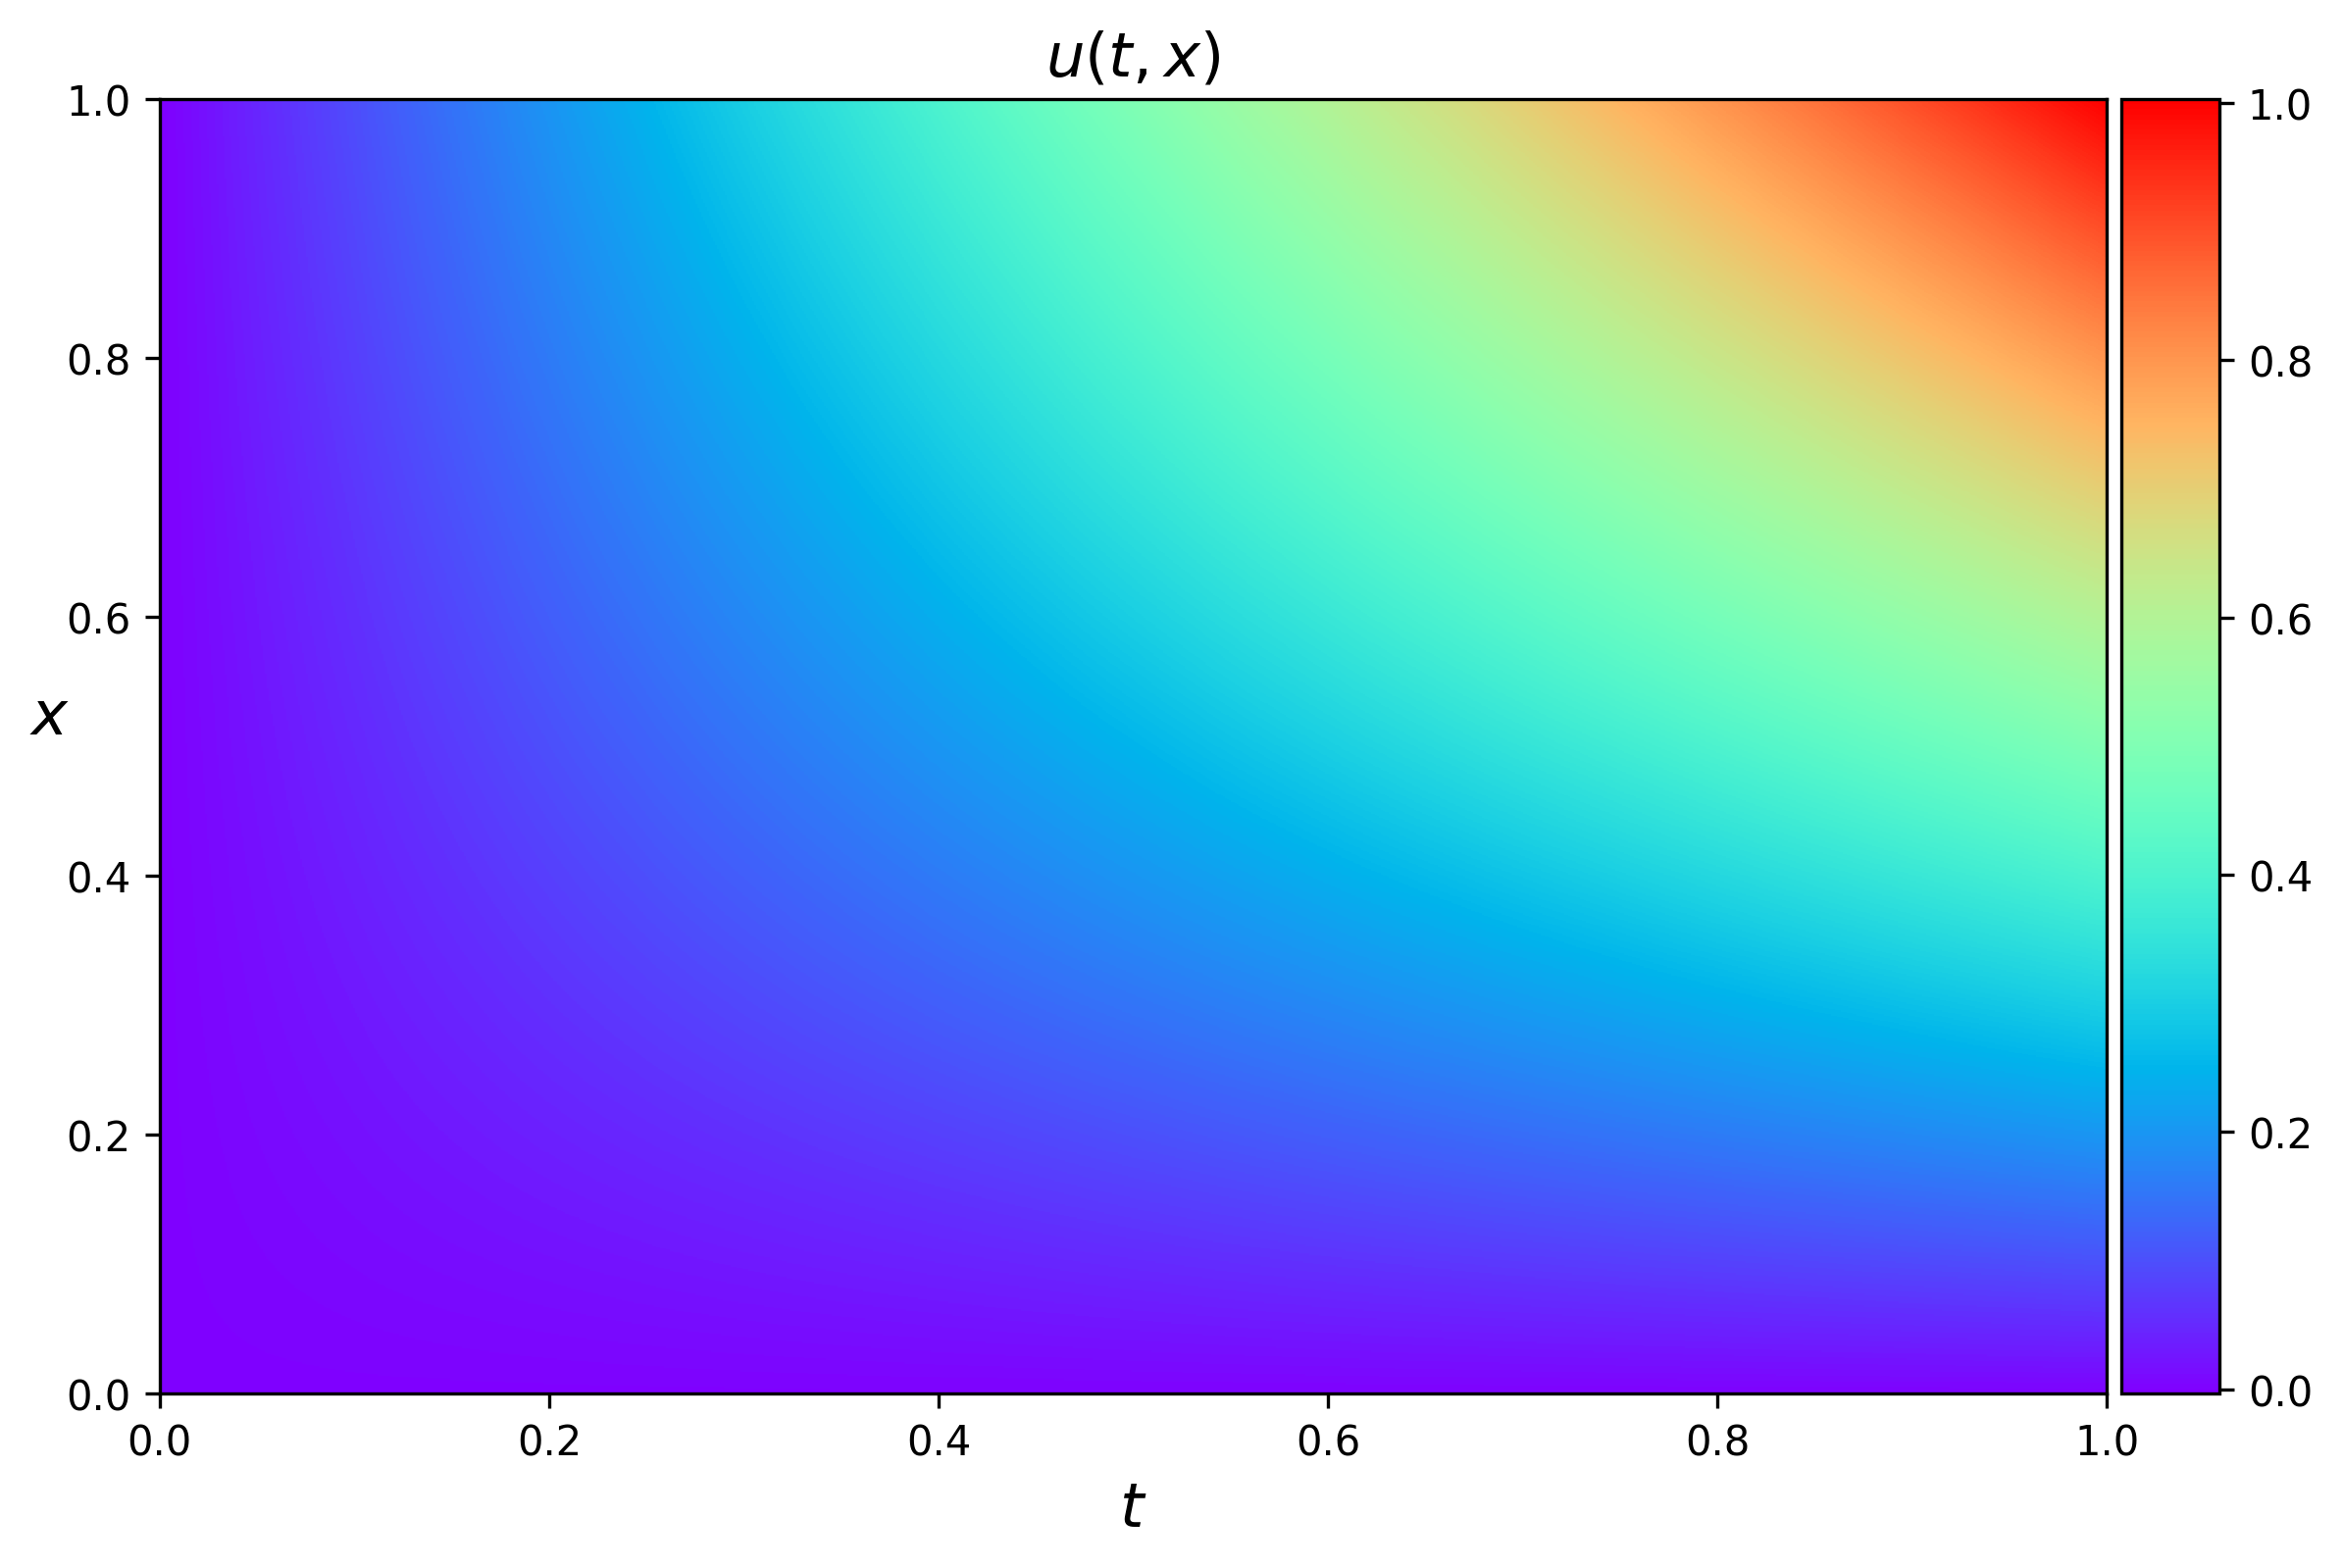

In [11]:
num_iter = 1000

alpha = 1.01

N_u = 1000
N_f = 10000

xy = np.mgrid[0:1:1/1000, 0:1:1/1000].reshape(2, -1).T
X_f_train = xy

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)

model_1_01 = EulerPINN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha)

start_time = time.time()
energy_1_01, loss_1_01, sgd_1_01 = model_1_01.train(num_iter)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model_1_01.predict(X_star)

F_pred = tf.reshape(tf.square(f_pred[0]) + tf.square(f_pred[1]), X.shape)
U_pred = tf.reshape(u_pred, X.shape)

######################################################################
############################# Plotting ###############################
######################################################################

fig = plt.figure(figsize = [10, 10], dpi = 300)

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.numpy().T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$', fontsize = 15)
ax.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax.set_title('$u(t,x)$', fontsize = 15)
ax.legend(frameon=False, loc = 'best')

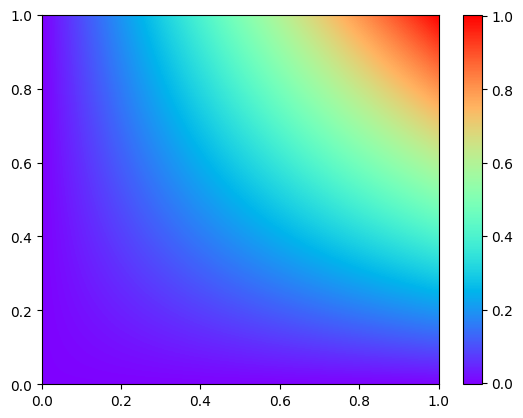

In [13]:
U_pred_1_01 = U_pred.numpy()
plt.imshow(U_pred_1_01.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar()

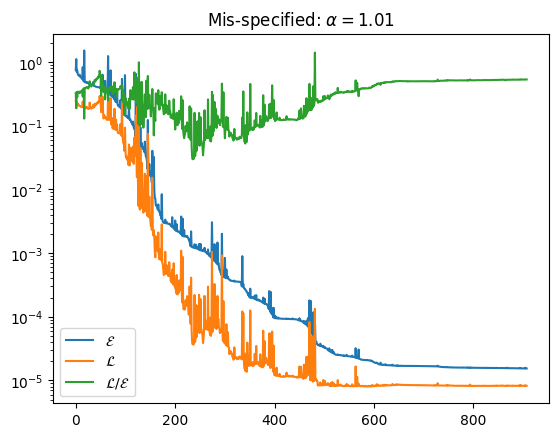

In [15]:
window_size = 1
energy_avg = moving_average(energy_1_01[10:], window_size)
loss_avg = moving_average(loss_1_01[10:], window_size)
sgd_avg = moving_average(sgd_1_01[10:], window_size)

from matplotlib import pyplot as plt
import numpy as np

plt.plot(energy_avg[10:], label=r'$\mathcal{E}$')
#plt.plot(loss_avg[10:], label=r'$\mathcal{\hat{L}}$')
plt.plot(sgd_avg[10:], label=r'$\mathcal{L}$')
plt.plot(np.array(sgd_avg[10:])/np.array(energy_avg[10:]), label=r'$\mathcal{L}/\mathcal{E}$')
plt.title(r'Mis-specified: $\alpha=1.01$')
plt.legend()
plt.yscale('log')
plt.show()

## Mis-specified: $\alpha=2$

Iter: 10 Euler loss: 14.1182442 old loss: 3.31267548 sgd loss: 3.31609702
Iter: 20 Euler loss: 1.16133785 old loss: 0.533852339 sgd loss: 0.534473598
Iter: 30 Euler loss: 1.11519265 old loss: 0.548047543 sgd loss: 0.548832536
Iter: 40 Euler loss: 1.15100181 old loss: 0.631397963 sgd loss: 0.631918669
Iter: 50 Euler loss: 0.758074105 old loss: 0.521586418 sgd loss: 0.521535039
Iter: 60 Euler loss: 0.707511127 old loss: 0.421461105 sgd loss: 0.421328843
Iter: 70 Euler loss: 0.622383714 old loss: 0.400111198 sgd loss: 0.400107563
Iter: 80 Euler loss: 0.365101 old loss: 0.280997962 sgd loss: 0.280951887
Iter: 90 Euler loss: 0.305559635 old loss: 0.129003406 sgd loss: 0.128997236
Iter: 100 Euler loss: 0.276444584 old loss: 0.169700027 sgd loss: 0.169601232
Iter: 110 Euler loss: 0.18770352 old loss: 0.133972913 sgd loss: 0.133929774
Iter: 120 Euler loss: 0.173542053 old loss: 0.132600486 sgd loss: 0.132608563
Iter: 130 Euler loss: 0.156938151 old loss: 0.12595275 sgd loss: 0.125977457
Iter: 

/tmp/ipython-input-1438678913.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc = 'best')


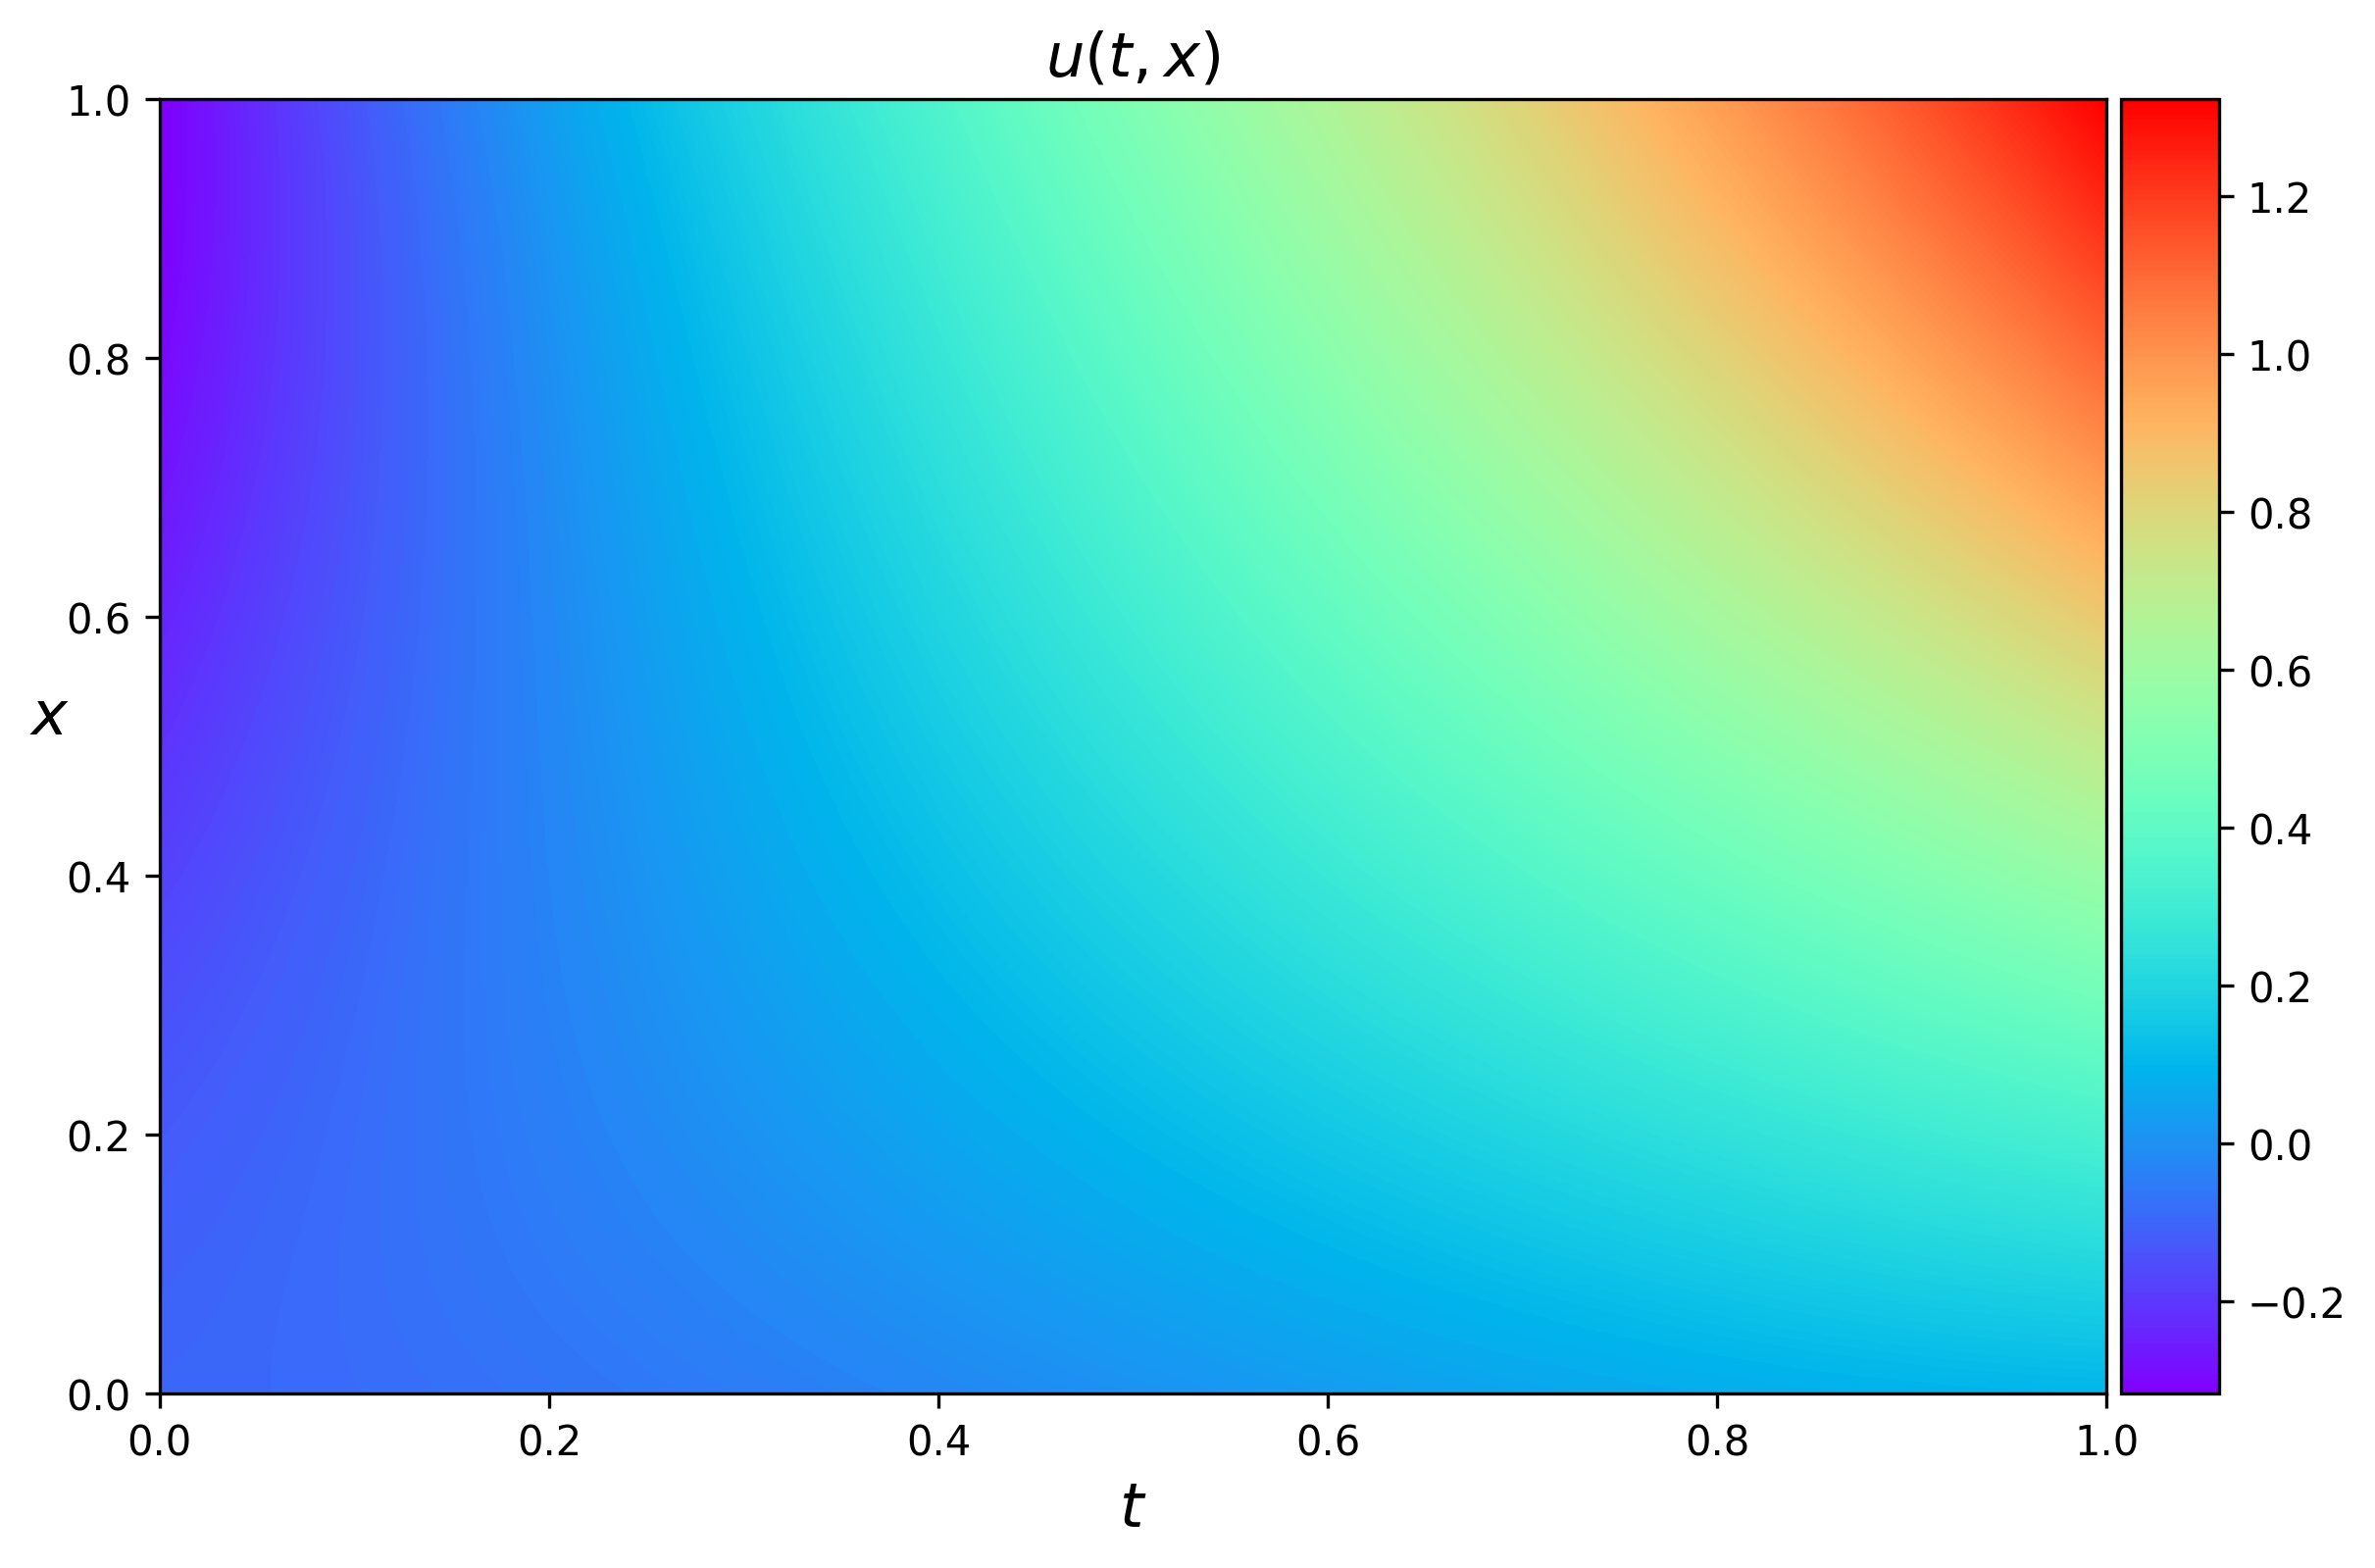

In [16]:
num_iter = 1000

alpha = 2

N_u = 1000
N_f = 10000

xy = np.mgrid[0:1:1/1000, 0:1:1/1000].reshape(2, -1).T
X_f_train = xy

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)

model_2 = EulerPINN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha)

start_time = time.time()
energy_2, loss_2, sgd_2 = model_2.train(num_iter)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model_2.predict(X_star)

F_pred = tf.reshape(tf.square(f_pred[0]) + tf.square(f_pred[1]), X.shape)
U_pred = tf.reshape(u_pred, X.shape)

######################################################################
############################# Plotting ###############################
######################################################################

fig = plt.figure(figsize = [10, 10], dpi = 300)

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.numpy().T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$', fontsize = 15)
ax.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax.set_title('$u(t,x)$', fontsize = 15)
ax.legend(frameon=False, loc = 'best')

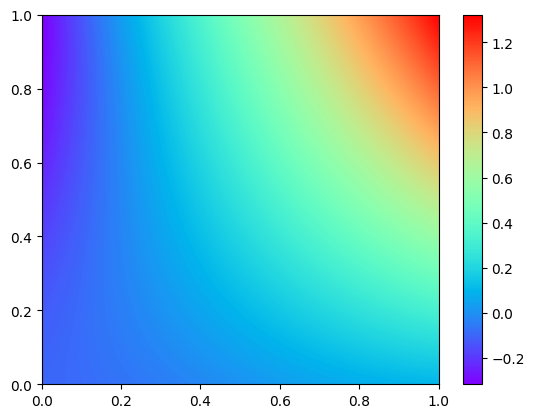

In [18]:
U_pred_2 = U_pred.numpy()
plt.imshow(U_pred_2.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar()

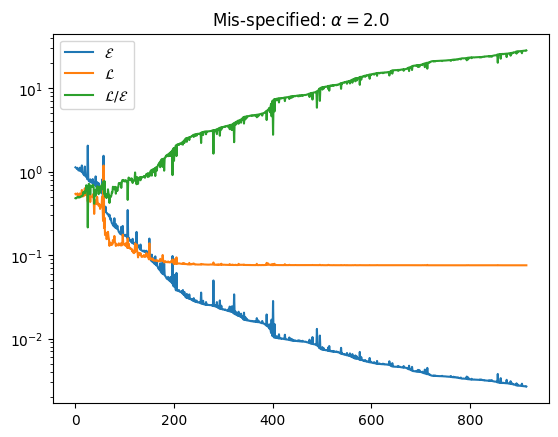

In [17]:
window_size = 1
energy_avg = moving_average(energy_2[10:], window_size)
loss_avg = moving_average(loss_2[10:], window_size)
sgd_avg = moving_average(sgd_2[10:], window_size)

from matplotlib import pyplot as plt
import numpy as np

plt.plot(energy_avg[10:], label=r'$\mathcal{E}$')
#plt.plot(loss_avg[10:], label=r'$\mathcal{\hat{L}}$')
plt.plot(sgd_avg[10:], label=r'$\mathcal{L}$')
plt.plot(np.array(sgd_avg[10:])/np.array(energy_avg[10:]), label=r'$\mathcal{L}/\mathcal{E}$')
plt.title(r'Mis-specified: $\alpha=2.0$')
plt.legend()
plt.yscale('log')
plt.show()

## Mis-specified: $\alpha=0.99$

Iter: 10 Euler loss: 1.1949625 old loss: 0.431116879 sgd loss: 0.431715369
Iter: 20 Euler loss: 0.569921315 old loss: 0.244296685 sgd loss: 0.244531214
Iter: 30 Euler loss: 0.404085875 old loss: 0.224847138 sgd loss: 0.224914879
Iter: 40 Euler loss: 0.375599027 old loss: 0.218621343 sgd loss: 0.218702838
Iter: 50 Euler loss: 0.349308074 old loss: 0.19651635 sgd loss: 0.196586177
Iter: 60 Euler loss: 0.311816216 old loss: 0.106430352 sgd loss: 0.1065716
Iter: 70 Euler loss: 0.141672134 old loss: 0.0316596329 sgd loss: 0.0316265188
Iter: 80 Euler loss: 0.0751360208 old loss: 0.0188839938 sgd loss: 0.0188488774
Iter: 90 Euler loss: 0.0606132746 old loss: 0.0171508752 sgd loss: 0.0171267446
Iter: 100 Euler loss: 0.0464434326 old loss: 0.0147785787 sgd loss: 0.0147663802
Iter: 110 Euler loss: 0.0393909141 old loss: 0.00734153297 sgd loss: 0.00733884238
Iter: 120 Euler loss: 0.0352659822 old loss: 0.0104306247 sgd loss: 0.0104332119
Iter: 130 Euler loss: 0.0174688771 old loss: 0.00674413 sgd

/tmp/ipython-input-2198658754.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc = 'best')


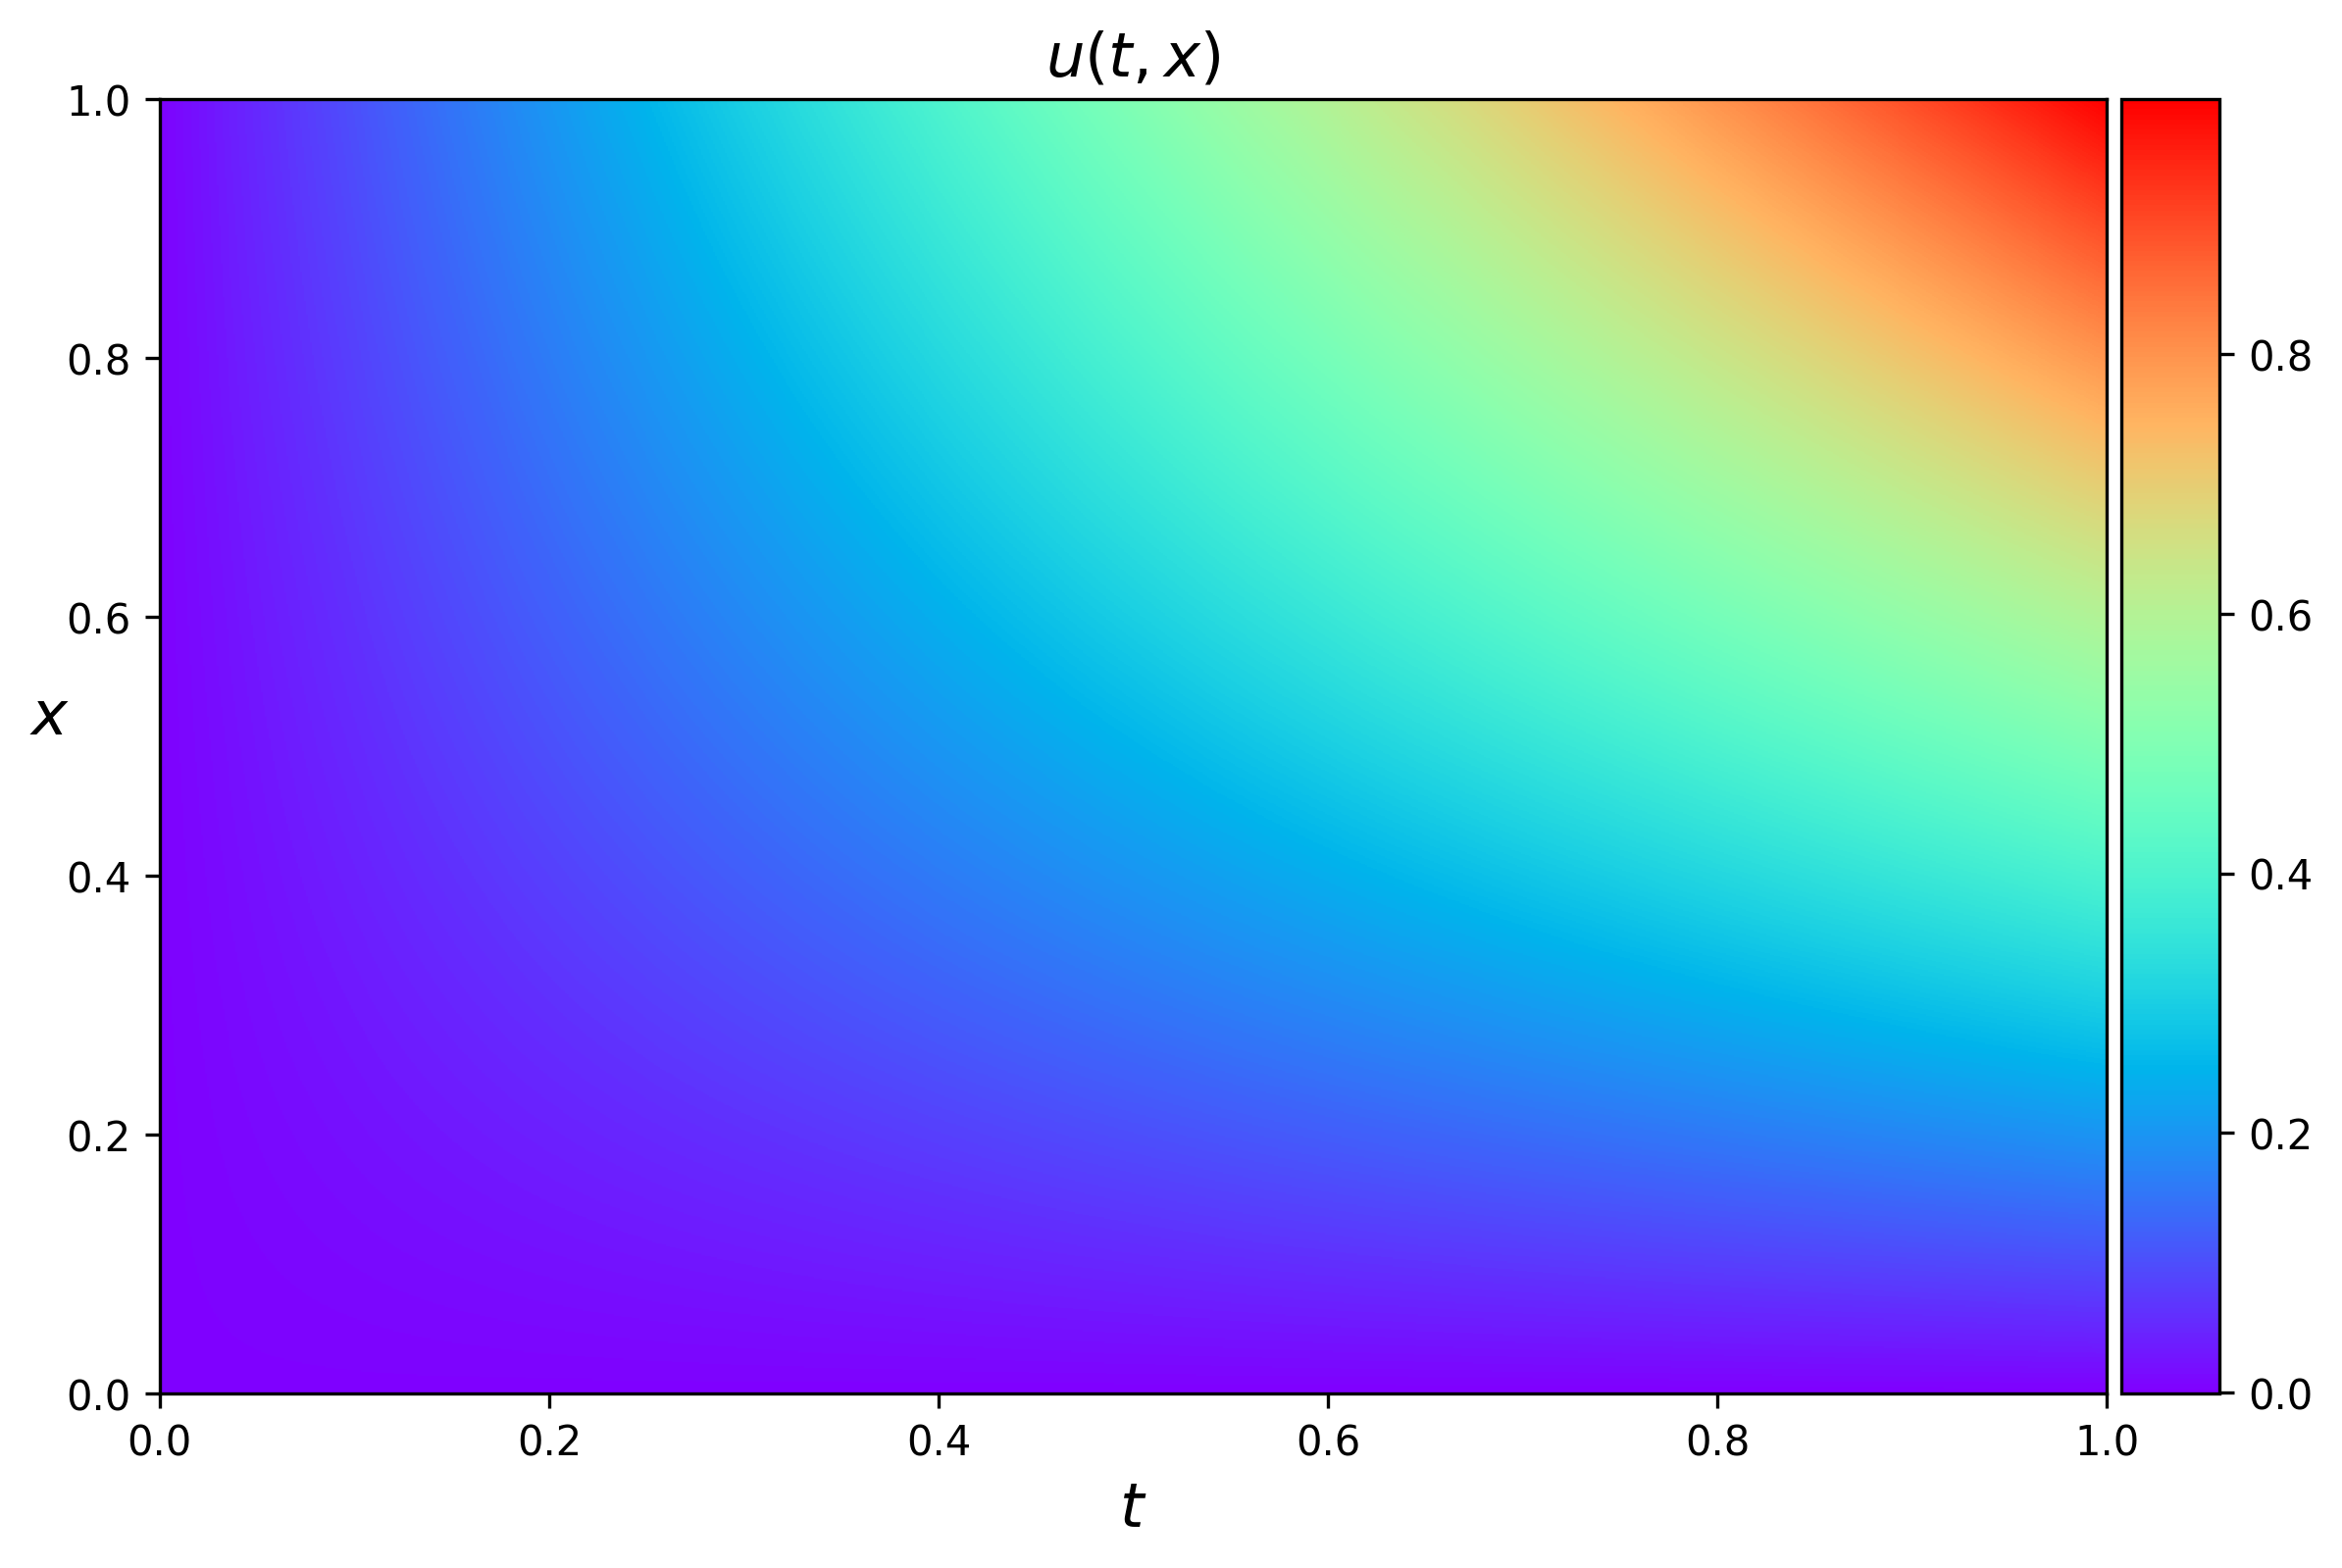

In [19]:
num_iter = 1000

alpha = 0.99

N_u = 1000
N_f = 10000

xy = np.mgrid[0:1:1/1000, 0:1:1/1000].reshape(2, -1).T
X_f_train = xy

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)

model_0_99 = EulerPINN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha)

start_time = time.time()
energy_0_99, loss_0_99, sgd_0_99 = model_0_99.train(num_iter)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model_0_99.predict(X_star)

F_pred = tf.reshape(tf.square(f_pred[0]) + tf.square(f_pred[1]), X.shape)
U_pred = tf.reshape(u_pred, X.shape)

######################################################################
############################# Plotting ###############################
######################################################################

fig = plt.figure(figsize = [10, 10], dpi = 300)

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.numpy().T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$', fontsize = 15)
ax.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax.set_title('$u(t,x)$', fontsize = 15)
ax.legend(frameon=False, loc = 'best')

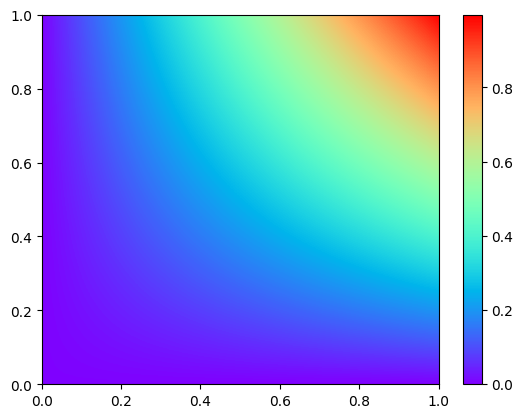

In [20]:
U_pred_0_99 = U_pred.numpy()
plt.imshow(U_pred_0_99.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar()

In [21]:
# Save work

np.save('U_pred_0_99.npy', U_pred_0_99)
np.save('U_pred_1.npy', U_pred_1)
np.save('U_pred_1_01.npy', U_pred_1_01)
np.save('U_pred_2.npy', U_pred_2)

np.save('energy_0_99.npy', energy_0_99)
np.save('energy_1.npy', energy)
np.save('energy_1_01.npy', energy_1_01)
np.save('energy_2.npy', energy_2)

np.save('loss_0_99.npy', loss_0_99)
np.save('loss_1.npy', loss)
np.save('loss_1_01.npy', loss_1_01)
np.save('loss_2.npy', loss_2)

np.save('sgd_0_99.npy', sgd_0_99)
np.save('sgd_1.npy', sgd)
np.save('sgd_1_01.npy', sgd_1_01)
np.save('sgd_2.npy', sgd_2)

# Evaluate solutions, plot predictions and loss curves

In [38]:
ground_truth = (X_star[:,0] * X_star[:,1]).numpy().reshape(U_pred_1.shape)

np.mean(np.square(U_pred_1 - ground_truth)) / np.mean(np.square(ground_truth)), np.mean(np.square(U_pred_0_99 - ground_truth)) / np.mean(np.square(ground_truth)), np.mean(np.square(U_pred_1_01 - ground_truth)) / np.mean(np.square(ground_truth)), np.mean(np.square(U_pred_2 - ground_truth)) / np.mean(np.square(ground_truth))

(np.float32(7.552297e-07),
 np.float32(1.5596019e-05),
 np.float32(1.551417e-05),
 np.float32(0.14673485))

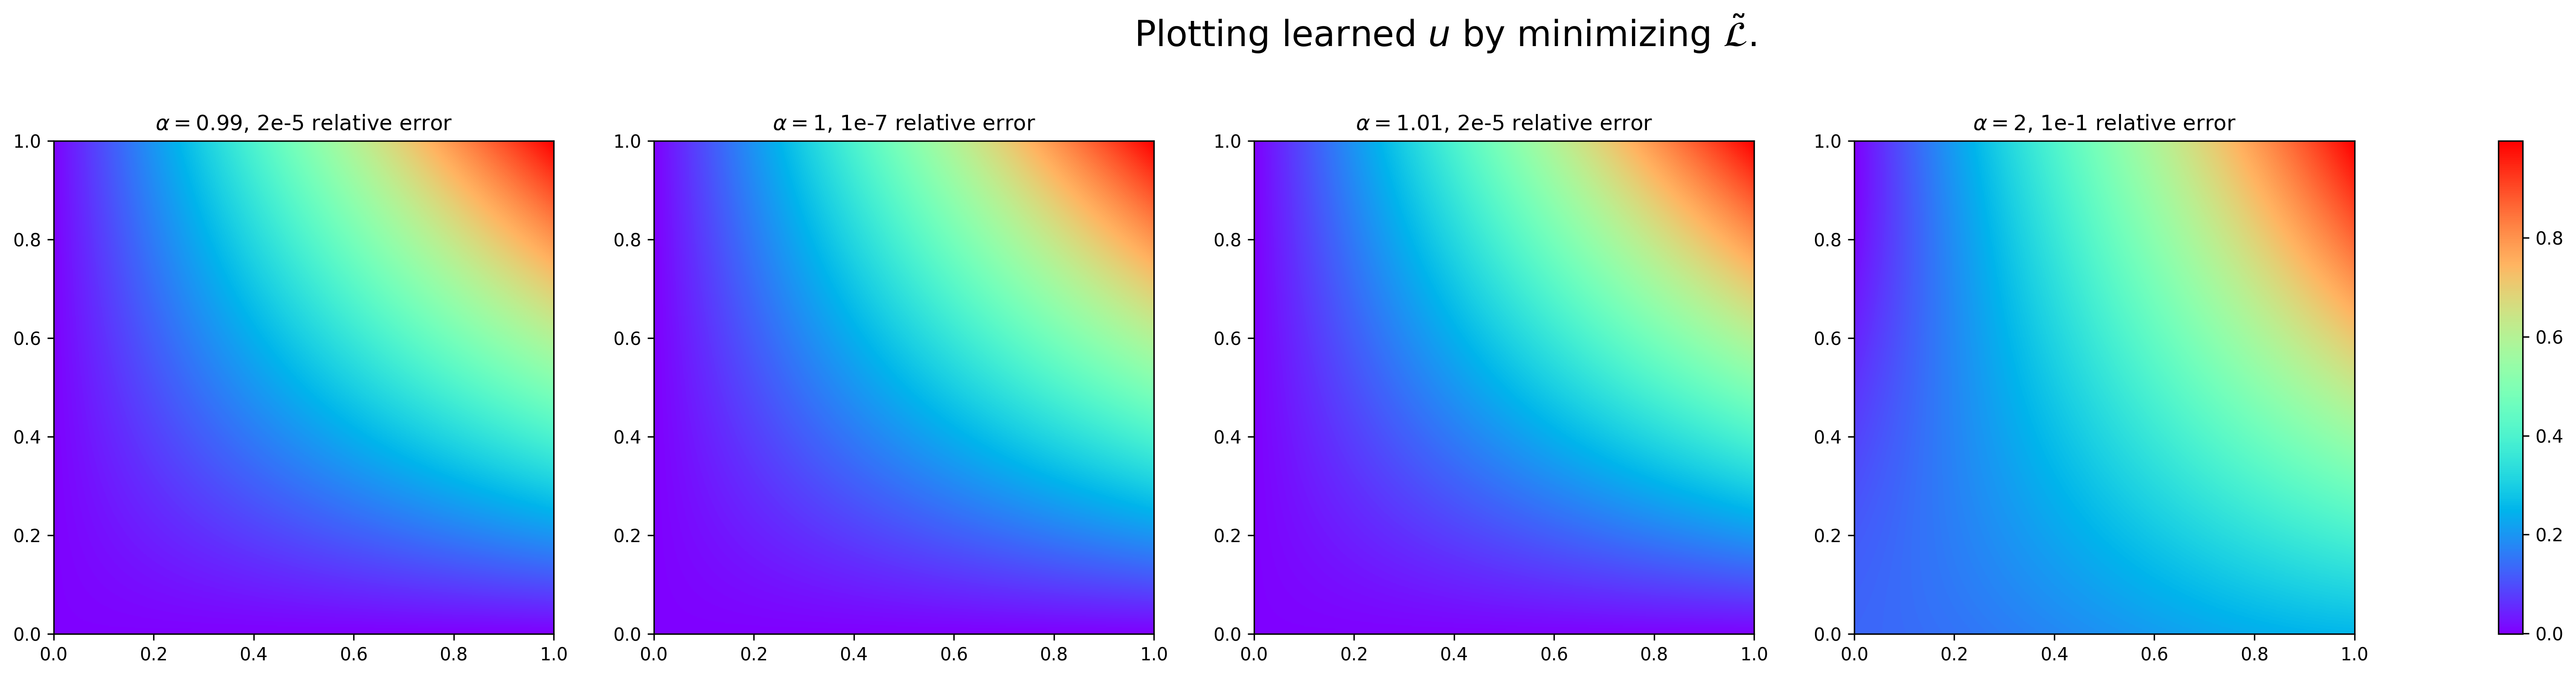

In [39]:
f, axs = plt.subplots(1, 4, figsize=(29,5), dpi=300)

# Plot U_pred for each alpha:

axs[0].imshow(U_pred_0_99.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

axs[1].imshow(U_pred_1.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

axs[2].imshow(U_pred_1_01.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

axs[3].imshow(U_pred_2.T, interpolation='nearest', cmap='rainbow',
              extent=[y.min(), y.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

axs[0].set_title(r'$\alpha=0.99$, 2e-5 relative error')
axs[1].set_title(r'$\alpha=1$, 1e-7 relative error')
axs[2].set_title(r'$\alpha=1.01$, 2e-5 relative error')
axs[3].set_title(r'$\alpha=2$, 1e-1 relative error')

f.suptitle(r"Plotting learned $u$ by minimizing $\tilde{\mathcal{L}}$.", fontsize=20, y=1.08)

plt.colorbar(axs[0].images[0], ax=axs.ravel().tolist())

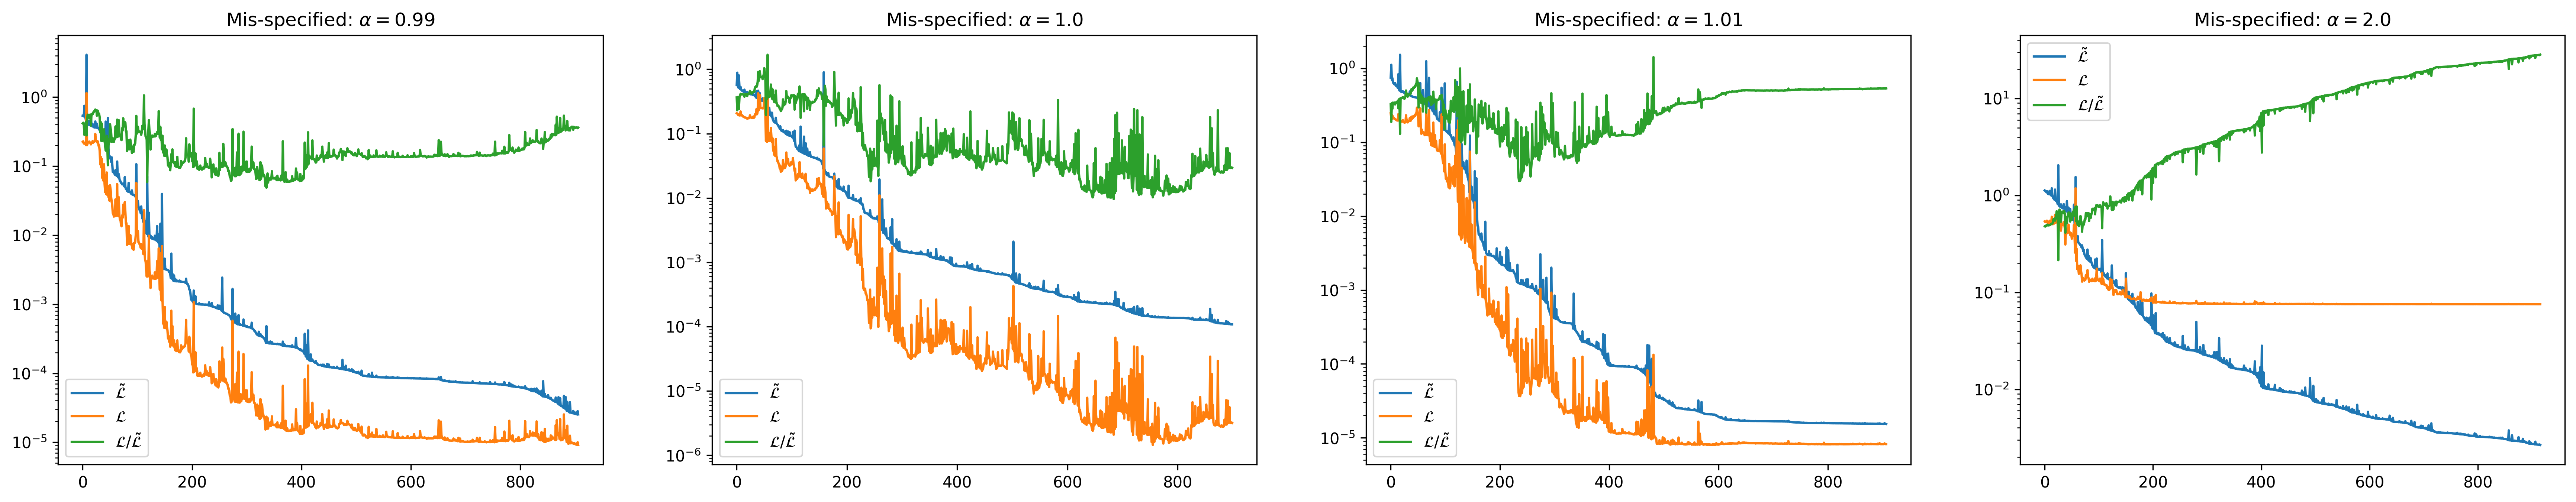

In [44]:

f, axs = plt.subplots(1, 4, figsize=(29,5), dpi=300)

for counter, alpha, e, l, s in zip([0,1,2,3], [0.99, 1.00, 1.01, 2.00], [energy_0_99, energy, energy_1_01, energy_2], [loss_0_99, loss, loss_1_01, loss_2], [sgd_0_99, sgd, sgd_1_01, sgd_2]):
  window_size = 1
  energy_avg = moving_average(e[10:], window_size)
  loss_avg = moving_average(l[10:], window_size)
  sgd_avg = moving_average(s[10:], window_size)

  from matplotlib import pyplot as plt
  import numpy as np

  plt.sca(axs[counter])
  plt.plot(energy_avg[10:], label=r'$\tilde{\mathcal{L}}$')
  #plt.plot(loss_avg[10:], label=r'$\mathcal{\hat{L}}$')
  plt.plot(sgd_avg[10:], label=r'$\mathcal{L}$')
  plt.plot(np.array(sgd_avg[10:])/np.array(energy_avg[10:]), label=r'$\mathcal{L}/\tilde\mathcal{L}$')
  plt.title(rf'Mis-specified: $\alpha={alpha}$')
  plt.legend()
  plt.yscale('log')